## Project 2

### Classification of SBA loans

#### Importing the needed libraries

In [1]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

## Preparation

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 1500)

import warnings
warnings.filterwarnings('ignore')

#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
"""
Created on Mon Mar 18 18:25:50 2019

@author: Uri Smashnov

Purpose: Analyze input Pandas DataFrame and return stats per column
Details: The function calculates levels for categorical variables and allows to analyze summarized information

To view wide table set following Pandas options:
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth',200)
"""
import pandas as pd
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=True):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=dropna))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=dropna)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=dropna).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

## Load the SBA_loans dataset

In [5]:
data = pd.read_csv('SBA_loans_project_2.csv')           #store csv file in 'data' dataframe

In [6]:
print("Data shape:", data.shape)                        #Dimensions of the dataframe

Data shape: (809247, 19)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809247 entries, 0 to 809246
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   City               809222 non-null  object 
 1   State              809235 non-null  object 
 2   Zip                809247 non-null  int64  
 3   Bank               807854 non-null  object 
 4   BankState          807849 non-null  object 
 5   NAICS              809247 non-null  int64  
 6   NoEmp              809247 non-null  int64  
 7   NewExist           809126 non-null  float64
 8   CreateJob          809247 non-null  int64  
 9   RetainedJob        809247 non-null  int64  
 10  FranchiseCode      809247 non-null  int64  
 11  UrbanRural         809247 non-null  int64  
 12  RevLineCr          805164 non-null  object 
 13  LowDoc             806923 non-null  object 
 14  DisbursementGross  809247 non-null  object 
 15  BalanceGross       809247 non-null  object 
 16  Gr

### Review the dataset 

In [8]:
desc_df = describe_more(data)
desc_df 

A_Variable  Levels Datatype  Min Length  Max Length  \
0                City   31289   object           1          30   
1               State      51   object           2           3   
2                 Zip   32740    int64           1           5   
3                Bank    5699   object           3          30   
4           BankState      56   object           2           3   
5               NAICS    1309    int64           1           6   
6               NoEmp     576    int64           1           4   
7            NewExist       3  float64           3           3   
8           CreateJob     232    int64           1           4   
9         RetainedJob     347    int64           1           4   
10      FranchiseCode    2685    int64           1           5   
11         UrbanRural       3    int64           1           1   
12          RevLineCr      18   object           1           3   
13             LowDoc       8   object           1           3   
14  DisbursementGross  110650   object           6          15   
15       BalanceGross      15   object           6          12   
16             GrAppv   20749   object           8          14   
17           SBA_Appv   35956   object           8          14   
18         MIS_Status       2   object           3           6   

                                         Level_Values  
0   {'LOS ANGELES': 10421, 'HOUSTON': 9194, 'NEW Y...  
1   {'CA': 117735, 'TX': 63313, 'NY': 52031, 'FL':...  
2   {90015: 843, 10001: 823, 93401: 726, 90010: 66...  
3   {'BANK OF AMERICA NATL ASSOC': 78119, 'WELLS F...  
4   {'CA': 106451, 'NC': 71484, 'IL': 59292, 'OH':...  
5   {0: 181606, 722110: 25266, 722211: 17505, 8111...  
6   {1: 138747, 2: 124352, 3: 81499, 4: 66471, 5: ...  
7                {1.0: 580544, 2.0: 227662, 0.0: 920}  
8   {0: 566266, 1: 56838, 2: 52098, 3: 25928, 4: 1...  
9   {0: 396245, 1: 79902, 2: 69113, 3: 44894, 4: 3...  
10  {1: 574567, 0: 188154, 78760: 3043, 68020: 173...  
11                   {1: 423475, 0: 290853, 2: 94919}  
12  {'N': 378024, '0': 231849, 'Y': 181502, 'T': 1...  
13  {'N': 704491, 'Y': 99348, '0': 1340, 'C': 689,...  
14  {'$50,000.00 ': 39461, '$100,000.00 ': 33061, ...  
15  {'$0.00 ': 809233, '$41,509.00 ': 1, '$9,111.0...  
16  {'$50,000.00 ': 62633, '$25,000.00 ': 46149, '...  
17  {'$25,000.00 ': 44810, '$12,500.00 ': 36149, '...  
18                {'P I F': 665817, 'CHGOFF': 141634}

## Cleaning the data

Displaying the null values against each feature

In [9]:
SBA=data.copy()                 

list_item = []
for col in SBA.columns:
    list_item.append([col, SBA[col].dtype, SBA[col].isna().sum(), round((SBA[col].isna().sum()/len(SBA[col]))*100,2),
                      SBA[col].nunique(), list(SBA[col].sample(5).drop_duplicates().values)])

dfDesc = pd.DataFrame(columns=['feature', 'data_type', 'null', 'nulPct', 'unique', 'uniqueSample'],data=list_item)
dfDesc

feature data_type  null  nulPct  unique  \
0                City    object    25    0.00   31289   
1               State    object    12    0.00      51   
2                 Zip     int64     0    0.00   32740   
3                Bank    object  1393    0.17    5699   
4           BankState    object  1398    0.17      56   
5               NAICS     int64     0    0.00    1309   
6               NoEmp     int64     0    0.00     576   
7            NewExist   float64   121    0.01       3   
8           CreateJob     int64     0    0.00     232   
9         RetainedJob     int64     0    0.00     347   
10      FranchiseCode     int64     0    0.00    2685   
11         UrbanRural     int64     0    0.00       3   
12          RevLineCr    object  4083    0.50      18   
13             LowDoc    object  2324    0.29       8   
14  DisbursementGross    object     0    0.00  110650   
15       BalanceGross    object     0    0.00      15   
16             GrAppv    object     0    0.00   20749   
17           SBA_Appv    object     0    0.00   35956   
18         MIS_Status    object  1796    0.22       2   

                                         uniqueSample  
0   [WINTERPORT, LAWRENCEVILLE, PENSACOLA, HOT SPR...  
1                                    [WA, MN, WI, VT]  
2                 [32773, 24701, 33487, 28469, 53151]  
3   [U.S. BANK NATIONAL ASSOCIATION, JPMORGAN CHAS...  
4                                [RI, ID, CA, OH, DE]  
5                 [423220, 0, 811412, 311712, 621391]  
6                                   [10, 4, 8, 15, 1]  
7                                          [2.0, 1.0]  
8                                              [0, 2]  
9                                          [0, 1, 16]  
10                                      [1, 51720, 0]  
11                                             [1, 0]  
12                                          [Y, 0, N]  
13                                                [N]  
14  [$5,000.00 , $60,000.00 , $545,000.00 , $210,0...  
15                                           [$0.00 ]  
16  [$113,600.00 , $125,000.00 , $277,000.00 , $15...  
17  [$36,000.00 , $17,500.00 , $999,000.00 , $11,2...  
18                                            [P I F]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809247 entries, 0 to 809246
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   City               809222 non-null  object 
 1   State              809235 non-null  object 
 2   Zip                809247 non-null  int64  
 3   Bank               807854 non-null  object 
 4   BankState          807849 non-null  object 
 5   NAICS              809247 non-null  int64  
 6   NoEmp              809247 non-null  int64  
 7   NewExist           809126 non-null  float64
 8   CreateJob          809247 non-null  int64  
 9   RetainedJob        809247 non-null  int64  
 10  FranchiseCode      809247 non-null  int64  
 11  UrbanRural         809247 non-null  int64  
 12  RevLineCr          805164 non-null  object 
 13  LowDoc             806923 non-null  object 
 14  DisbursementGross  809247 non-null  object 
 15  BalanceGross       809247 non-null  object 
 16  Gr

### Filling the Null values with "Missing" and "0"

In [11]:
values_to_fill = {}
for col in data:
    if data[col].dtype == 'object':
        values_to_fill[col] = "Missing"
    else:
        values_to_fill[col] = 0

data.fillna(value=values_to_fill,inplace=True)
data.fillna(value=values_to_fill, inplace=True)

Display showing no presence of null values in the data

In [12]:
data.info()             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809247 entries, 0 to 809246
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   City               809247 non-null  object 
 1   State              809247 non-null  object 
 2   Zip                809247 non-null  int64  
 3   Bank               809247 non-null  object 
 4   BankState          809247 non-null  object 
 5   NAICS              809247 non-null  int64  
 6   NoEmp              809247 non-null  int64  
 7   NewExist           809247 non-null  float64
 8   CreateJob          809247 non-null  int64  
 9   RetainedJob        809247 non-null  int64  
 10  FranchiseCode      809247 non-null  int64  
 11  UrbanRural         809247 non-null  int64  
 12  RevLineCr          809247 non-null  object 
 13  LowDoc             809247 non-null  object 
 14  DisbursementGross  809247 non-null  object 
 15  BalanceGross       809247 non-null  object 
 16  Gr

In [13]:
data.isna().sum()

City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
BalanceGross         0
GrAppv               0
SBA_Appv             0
MIS_Status           0
dtype: int64

### Defining a function to remove $ and , in the features that display currency and converting them to int data type

In [14]:
def currencyCleaning(x):
    x = x[1:].replace(',','')
    return x

In [15]:
data['DisbursementGross'] = data['DisbursementGross'].apply(currencyCleaning).astype(float).astype(int)
data['SBA_Appv'] = data['SBA_Appv'].apply(currencyCleaning).astype(float).astype(int)
data['BalanceGross'] = data['BalanceGross'].apply(currencyCleaning).astype(float).astype(int)
data['GrAppv'] = data['GrAppv'].apply(currencyCleaning).astype(float).astype(int)


In [16]:
data

City State    Zip                            Bank  \
0                     BRADLEY    WV  25818     CITY NATL BK OF W. VIRGINIA   
1                    LA JOLLA    CA  92037  U.S. BANK NATIONAL ASSOCIATION   
2                     WINSLOW    AZ  86047  SOUTHWESTERN BUS. FINANCING CO   
3                      OXNARD    CA  93030              CITY NATIONAL BANK   
4                    MERIDIAN    MS  39301         TRUSTMARK NATIONAL BANK   
...                       ...   ...    ...                             ...   
809242                   KENT    WA  98030  U.S. BANK NATIONAL ASSOCIATION   
809243          PROSPECT PARK    PA  19076   TD BANK, NATIONAL ASSOCIATION   
809244            CASTLE ROCK    CO  80104   COLORADO LENDING SOURCE, LTD.   
809245  CHEEKTOWAGA (TOWN OF)    NY  14227      BANK OF AMERICA NATL ASSOC   
809246               STERLING    VA  20164            WASHINGTONFIRST BANK   

       BankState   NAICS  NoEmp  NewExist  CreateJob  RetainedJob  \
0             WV       0      7       1.0          0            0   
1             OH  531210      1       2.0          0            1   
2             AZ  721110     30       1.0          0            1   
3             CA       0      8       1.0          0            0   
4             MS       0      4       2.0          0            0   
...          ...     ...    ...       ...        ...          ...   
809242        OH  812112      4       1.0          0            4   
809243        DE  811113      1       1.0          3            1   
809244        CO  441310      5       1.0         10            5   
809245        RI  445110      9       1.0          3           12   
809246        VA  233320      4       2.0          0            0   

        FranchiseCode  UrbanRural RevLineCr LowDoc  DisbursementGross  \
0                   1           0         N      Y              30000   
1                   0           1         Y      N              50000   
2               10465           2         0      N            1297000   
3                   1           0         N      N             510000   
4                   1           0         N      N              87000   
...               ...         ...       ...    ...                ...   
809242              0           1         Y      N              28938   
809243          20550           2         0      N             150000   
809244              1           1         N      N             142000   
809245              1           1         0      N              28400   
809246              1           1         N      N             100000   

        BalanceGross   GrAppv  SBA_Appv MIS_Status  
0                  0    30000     27000      P I F  
1                  0    50000     25000      P I F  
2                  0  1300000   1300000      P I F  
3                  0   510000    433500      P I F  
4                  0    87000     78300      P I F  
...              ...      ...       ...        ...  
809242             0    20000     10000      P I F  
809243             0   150000    127500      P I F  
809244             0   165000    165000      P I F  
809245             0    28400     14200     CHGOFF  
809246             0   100000     75000      P I F  

[809247 rows x 19 columns]

### Converting MIS_Status to 0/1. Making value "CHGOFF" as 1

In [17]:
data['MIS_Status'] = [1 if status == 'CHGOFF' else 0 for status in data.MIS_Status.values] 
data

City State    Zip                            Bank  \
0                     BRADLEY    WV  25818     CITY NATL BK OF W. VIRGINIA   
1                    LA JOLLA    CA  92037  U.S. BANK NATIONAL ASSOCIATION   
2                     WINSLOW    AZ  86047  SOUTHWESTERN BUS. FINANCING CO   
3                      OXNARD    CA  93030              CITY NATIONAL BANK   
4                    MERIDIAN    MS  39301         TRUSTMARK NATIONAL BANK   
...                       ...   ...    ...                             ...   
809242                   KENT    WA  98030  U.S. BANK NATIONAL ASSOCIATION   
809243          PROSPECT PARK    PA  19076   TD BANK, NATIONAL ASSOCIATION   
809244            CASTLE ROCK    CO  80104   COLORADO LENDING SOURCE, LTD.   
809245  CHEEKTOWAGA (TOWN OF)    NY  14227      BANK OF AMERICA NATL ASSOC   
809246               STERLING    VA  20164            WASHINGTONFIRST BANK   

       BankState   NAICS  NoEmp  NewExist  CreateJob  RetainedJob  \
0             WV       0      7       1.0          0            0   
1             OH  531210      1       2.0          0            1   
2             AZ  721110     30       1.0          0            1   
3             CA       0      8       1.0          0            0   
4             MS       0      4       2.0          0            0   
...          ...     ...    ...       ...        ...          ...   
809242        OH  812112      4       1.0          0            4   
809243        DE  811113      1       1.0          3            1   
809244        CO  441310      5       1.0         10            5   
809245        RI  445110      9       1.0          3           12   
809246        VA  233320      4       2.0          0            0   

        FranchiseCode  UrbanRural RevLineCr LowDoc  DisbursementGross  \
0                   1           0         N      Y              30000   
1                   0           1         Y      N              50000   
2               10465           2         0      N            1297000   
3                   1           0         N      N             510000   
4                   1           0         N      N              87000   
...               ...         ...       ...    ...                ...   
809242              0           1         Y      N              28938   
809243          20550           2         0      N             150000   
809244              1           1         N      N             142000   
809245              1           1         0      N              28400   
809246              1           1         N      N             100000   

        BalanceGross   GrAppv  SBA_Appv  MIS_Status  
0                  0    30000     27000           0  
1                  0    50000     25000           0  
2                  0  1300000   1300000           0  
3                  0   510000    433500           0  
4                  0    87000     78300           0  
...              ...      ...       ...         ...  
809242             0    20000     10000           0  
809243             0   150000    127500           0  
809244             0   165000    165000           0  
809245             0    28400     14200           1  
809246             0   100000     75000           0  

[809247 rows x 19 columns]

In [18]:
desc_df1 = describe_more(data)
desc_df1

A_Variable  Levels Datatype  Min Length  Max Length  \
0                City   31290   object           1          30   
1               State      52   object           2           7   
2                 Zip   32740    int64           1           5   
3                Bank    5700   object           3          30   
4           BankState      57   object           2           7   
5               NAICS    1309    int64           1           6   
6               NoEmp     576    int64           1           4   
7            NewExist       3  float64           3           3   
8           CreateJob     232    int64           1           4   
9         RetainedJob     347    int64           1           4   
10      FranchiseCode    2685    int64           1           5   
11         UrbanRural       3    int64           1           1   
12          RevLineCr      19   object           1           7   
13             LowDoc       9   object           1           7   
14  DisbursementGross  110650    int32           1           8   
15       BalanceGross      15    int32           1           6   
16             GrAppv   20749    int32           3           7   
17           SBA_Appv   35956    int32           3           7   
18         MIS_Status       2    int64           1           1   

                                         Level_Values  
0   {'LOS ANGELES': 10421, 'HOUSTON': 9194, 'NEW Y...  
1   {'CA': 117735, 'TX': 63313, 'NY': 52031, 'FL':...  
2   {90015: 843, 10001: 823, 93401: 726, 90010: 66...  
3   {'BANK OF AMERICA NATL ASSOC': 78119, 'WELLS F...  
4   {'CA': 106451, 'NC': 71484, 'IL': 59292, 'OH':...  
5   {0: 181606, 722110: 25266, 722211: 17505, 8111...  
6   {1: 138747, 2: 124352, 3: 81499, 4: 66471, 5: ...  
7               {1.0: 580544, 2.0: 227662, 0.0: 1041}  
8   {0: 566266, 1: 56838, 2: 52098, 3: 25928, 4: 1...  
9   {0: 396245, 1: 79902, 2: 69113, 3: 44894, 4: 3...  
10  {1: 574567, 0: 188154, 78760: 3043, 68020: 173...  
11                   {1: 423475, 0: 290853, 2: 94919}  
12  {'N': 378024, '0': 231849, 'Y': 181502, 'T': 1...  
13  {'N': 704491, 'Y': 99348, 'Missing': 2324, '0'...  
14  {50000: 39461, 100000: 33061, 25000: 24665, 15...  
15  {0: 809233, 395476: 1, 41509: 1, 996262: 1, 11...  
16  {50000: 62633, 25000: 46149, 100000: 45900, 10...  
17  {25000: 44810, 12500: 36149, 5000: 28011, 5000...  
18                             {0: 667613, 1: 141634}

In [19]:
desc_df1.iloc[[7,11,12,13,18]]["Level_Values"]

7                 {1.0: 580544, 2.0: 227662, 0.0: 1041}
11                     {1: 423475, 0: 290853, 2: 94919}
12    {'N': 378024, '0': 231849, 'Y': 181502, 'T': 1...
13    {'N': 704491, 'Y': 99348, 'Missing': 2324, '0'...
18                               {0: 667613, 1: 141634}
Name: Level_Values, dtype: object

NAICS Level values

In [20]:
desc_df1.iloc[5]["Level_Values"]              

{0: 181606,
 722110: 25266,
 722211: 17505,
 811111: 13088,
 621210: 12579,
 624410: 9134,
 812112: 8265,
 561730: 8028,
 621310: 7836,
 812320: 7093,
 541110: 6355,
 445310: 6191,
 621111: 6078,
 721110: 6048,
 713940: 5926,
 447110: 5912,
 811121: 5663,
 451110: 5458,
 453220: 5412,
 484110: 5255,
 453998: 5097,
 238990: 4878,
 541330: 4876,
 445110: 4867,
 541940: 4793,
 811192: 4399,
 722410: 4103,
 236118: 4029,
 238220: 3896,
 235110: 3878,
 541511: 3819,
 524210: 3703,
 541512: 3676,
 812990: 3664,
 236115: 3479,
 531210: 3460,
 238210: 3438,
 722213: 3422,
 484121: 3411,
 812310: 3409,
 453110: 3308,
 445120: 3289,
 444130: 3276,
 561720: 3135,
 541611: 3089,
 448310: 3013,
 235310: 2975,
 448120: 2939,
 441120: 2755,
 112320: 2676,
 445299: 2670,
 442110: 2667,
 446110: 2599,
 812199: 2533,
 541430: 2476,
 441310: 2472,
 621320: 2448,
 541990: 2418,
 452990: 2389,
 442210: 2382,
 541810: 2347,
 233210: 2342,
 443120: 2244,
 541519: 2241,
 541211: 2205,
 541613: 2126,
 541310: 

Upon observing NAICS level values we see that NAICS is a six digit numeric code.

So, we remove all the data with incomplete NAICS code--where, NAICS is zero

In [21]:
data[data['NAICS']==0]

City State    Zip                            Bank BankState  \
0          BRADLEY    WV  25818     CITY NATL BK OF W. VIRGINIA        WV   
3           OXNARD    CA  93030              CITY NATIONAL BANK        CA   
4         MERIDIAN    MS  39301         TRUSTMARK NATIONAL BANK        MS   
10      CINCINNATI    OH  45237  HAMILTON CNTY DEVEL COMPANY IN        OH   
11          PELHAM    AL  35124           READYCAP LENDING, LLC        CA   
...            ...   ...    ...                             ...       ...   
809219      TACOMA    WA  98409   SMALL BUSINESS ADMINSITRATION        DC   
809221   VICKSBURG    MS  39180         TRUSTMARK NATIONAL BANK        MS   
809226      IRVING    TX  75062                BANK OF THE WEST        TX   
809235      TOLEDO    OH  43614    THE HUNTINGTON NATIONAL BANK        OH   
809237  GREENSBORO    NC  27410                   SUNTRUST BANK        GA   

        NAICS  NoEmp  NewExist  CreateJob  RetainedJob  FranchiseCode  \
0           0      7       1.0          0            0              1   
3           0      8       1.0          0            0              1   
4           0      4       2.0          0            0              1   
10          0     70       1.0         10           60              1   
11          0      5       1.0          2            5              1   
...       ...    ...       ...        ...          ...            ...   
809219      0      2       2.0          0            0              1   
809221      0      2       1.0          0            0              1   
809226      0      6       1.0          0            0              1   
809235      0      6       1.0          0            0              1   
809237      0      1       2.0          0            0              1   

        UrbanRural RevLineCr LowDoc  DisbursementGross  BalanceGross  GrAppv  \
0                0         N      Y              30000             0   30000   
3                0         N      N             510000             0  510000   
4                0         N      N              87000             0   87000   
10               0         N      N             319000             0  319000   
11               1         0      N             280000             0  280000   
...            ...       ...    ...                ...           ...     ...   
809219           0         N      N             344000             0  344000   
809221           0         N      N              40000             0   40000   
809226           0         N      N             200000             0  200000   
809235           1         0      Y              35000             0   35000   
809237           0         N      N              63000             0   63000   

        SBA_Appv  MIS_Status  
0          27000           0  
3         433500           0  
4          78300           0  
10        319000           0  
11        210000           0  
...          ...         ...  
809219    258000           0  
809221     36000           0  
809226    170000           0  
809235     28000           0  
809237     56700           0  

[181606 rows x 19 columns]

In [22]:
data.NAICS
NAICSTrue = 0
NAICSFalse = 0
for i in data.NAICS.astype(str):
    if len(i) == 6:
        NAICSTrue += 1
    else:
        NAICSFalse += 1
print(NAICSTrue)
print(NAICSFalse)

627641
181606


Single digit NAICS code has been excluded in data

In [23]:
data = data[data.NAICS != 0]           

In [24]:
data.NewExist.value_counts()

1.0    452830
2.0    174039
0.0       772
Name: NewExist, dtype: int64

According to the SBA Loans data, the only acceptable values for NewExist are 1.0 and 2.0 .
Here, 0.0 is incomplete categorisation of record. These two have been excluded.

In [25]:
data = data[(data.NewExist == 1.0) | (data.NewExist == 2.0)]
data.NewExist.value_counts()

1.0    452830
2.0    174039
Name: NewExist, dtype: int64

In [26]:
desc_df1.iloc[13]["Level_Values"]

{'N': 704491,
 'Y': 99348,
 'Missing': 2324,
 '0': 1340,
 'C': 689,
 'S': 536,
 'A': 449,
 'R': 69,
 '1': 1}

In [27]:
data.RevLineCr.value_counts()

N          242850
0          192843
Y          175860
T           13142
Missing      2132
R              13
1              12
`               5
2               5
C               2
Q               1
A               1
-               1
7               1
,               1
Name: RevLineCr, dtype: int64

According to the SBA Loans data, the only acceptable values for RevLineCr (Revolving Line of Credit) are N (No) and Y (Yes) . Here, all other categories have no meaning as to the categorisation of record. All such values have been excluded.

In [28]:
data = data[(data.RevLineCr == 'Y') | (data.RevLineCr == 'N')]
data.RevLineCr.value_counts()

N    242850
Y    175860
Name: RevLineCr, dtype: int64

In [29]:
data.LowDoc.value_counts()

N          392123
Y           22684
Missing      2280
C             509
S             505
0             463
A              92
R              53
1               1
Name: LowDoc, dtype: int64

According to the SBA Loans data, the only acceptable values for LowDoc are N (No) and Y (Yes) . Here, all other categories have no meaning as to the categorisation of record. All such values have been excluded.

In [30]:
data = data[(data.LowDoc == 'Y') | (data.LowDoc == 'N')]
data.LowDoc.value_counts()

N    392123
Y     22684
Name: LowDoc, dtype: int64

The view of data after preprocessing and cleaning

In [31]:
data

City State    Zip                            Bank BankState  \
1          LA JOLLA    CA  92037  U.S. BANK NATIONAL ASSOCIATION        OH   
5       DEVILS LAKE    ND  58301           CITIZENS COMMUNITY CU        ND   
6            DALLAS    OR  97338     WELLS FARGO BANK NATL ASSOC        SD   
7            Warren    NJ   7059   TD BANK, NATIONAL ASSOCIATION        DE   
8          HESPERIA    CA  92345      BANK OF AMERICA NATL ASSOC        NC   
...             ...   ...    ...                             ...       ...   
809239      MEDFORD    NY  11763          LONG ISLAND DEVEL CORP        NY   
809241        Elgin    OK  73538                     UMPQUA BANK        OR   
809242         KENT    WA  98030  U.S. BANK NATIONAL ASSOCIATION        OH   
809244  CASTLE ROCK    CO  80104   COLORADO LENDING SOURCE, LTD.        CO   
809246     STERLING    VA  20164            WASHINGTONFIRST BANK        VA   

         NAICS  NoEmp  NewExist  CreateJob  RetainedJob  FranchiseCode  \
1       531210      1       2.0          0            1              0   
5       453220      1       2.0          1            2              1   
6       234110      4       2.0          0            0              1   
7       722110      1       2.0         15            0              0   
8       811111      3       1.0          0            3              1   
...        ...    ...       ...        ...          ...            ...   
809239  332323     15       1.0          4           11              1   
809241  311811      2       2.0          0            2              0   
809242  812112      4       1.0          0            4              0   
809244  441310      5       1.0         10            5              1   
809246  233320      4       2.0          0            0              1   

        UrbanRural RevLineCr LowDoc  DisbursementGross  BalanceGross  GrAppv  \
1                1         Y      N              50000             0   50000   
5                2         Y      N              25000             0   25000   
6                0         N      N              64128             0   67000   
7                2         N      N             360000             0  360000   
8                1         Y      N              28162             0   24000   
...            ...       ...    ...                ...           ...     ...   
809239           0         N      N             128000             0  128000   
809241           1         N      N              50000             0   50000   
809242           1         Y      N              28938             0   20000   
809244           1         N      N             142000             0  165000   
809246           1         N      N             100000             0  100000   

        SBA_Appv  MIS_Status  
1          25000           0  
5          12500           0  
6          60300           0  
7         270000           0  
8          12000           0  
...          ...         ...  
809239    128000           0  
809241     42500           0  
809242     10000           0  
809244    165000           0  
809246     75000           0  

[414807 rows x 19 columns]

# Categorical Variables Encoding

'Zip' has been grouped under 'int' datatype. Whereas 'Zip' is a categorical column. So, the Zip feature has been converted to String type to denote text data.

In [32]:
data["Zip"] = data["Zip"].apply(str)  

### Target Encoding of the features

In [33]:
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from copy import deepcopy

'''Save original columns that need to be droped or not used
   Vave One-ho and Label encoders for future use
'''
cols_to_drop = []
cat_encoders = {}
#New categorical (encoded) columns
cat_enc_columns = []

for col in data.drop(columns=['MIS_Status']).columns:
    if data[col].dtype == 'object':
        print("Target Encode scaling of ", col)
        enc = ce.TargetEncoder()
        enc.fit(data[col],data['MIS_Status'])
        new_col_name = col+"_trg"
        data[new_col_name] = enc.transform(data[[col]])
        cat_encoders[col] = [deepcopy(enc),"trg"]
        cat_enc_columns.append(new_col_name)
        
    cols_to_drop.append(col)

Target Encode scaling of  City
Target Encode scaling of  State
Target Encode scaling of  Zip
Target Encode scaling of  Bank
Target Encode scaling of  BankState
Target Encode scaling of  RevLineCr
Target Encode scaling of  LowDoc


In [34]:
data

City State    Zip                            Bank BankState  \
1          LA JOLLA    CA  92037  U.S. BANK NATIONAL ASSOCIATION        OH   
5       DEVILS LAKE    ND  58301           CITIZENS COMMUNITY CU        ND   
6            DALLAS    OR  97338     WELLS FARGO BANK NATL ASSOC        SD   
7            Warren    NJ   7059   TD BANK, NATIONAL ASSOCIATION        DE   
8          HESPERIA    CA  92345      BANK OF AMERICA NATL ASSOC        NC   
...             ...   ...    ...                             ...       ...   
809239      MEDFORD    NY  11763          LONG ISLAND DEVEL CORP        NY   
809241        Elgin    OK  73538                     UMPQUA BANK        OR   
809242         KENT    WA  98030  U.S. BANK NATIONAL ASSOCIATION        OH   
809244  CASTLE ROCK    CO  80104   COLORADO LENDING SOURCE, LTD.        CO   
809246     STERLING    VA  20164            WASHINGTONFIRST BANK        VA   

         NAICS  NoEmp  NewExist  CreateJob  RetainedJob  FranchiseCode  \
1       531210      1       2.0          0            1              0   
5       453220      1       2.0          1            2              1   
6       234110      4       2.0          0            0              1   
7       722110      1       2.0         15            0              0   
8       811111      3       1.0          0            3              1   
...        ...    ...       ...        ...          ...            ...   
809239  332323     15       1.0          4           11              1   
809241  311811      2       2.0          0            2              0   
809242  812112      4       1.0          0            4              0   
809244  441310      5       1.0         10            5              1   
809246  233320      4       2.0          0            0              1   

        UrbanRural RevLineCr LowDoc  DisbursementGross  BalanceGross  GrAppv  \
1                1         Y      N              50000             0   50000   
5                2         Y      N              25000             0   25000   
6                0         N      N              64128             0   67000   
7                2         N      N             360000             0  360000   
8                1         Y      N              28162             0   24000   
...            ...       ...    ...                ...           ...     ...   
809239           0         N      N             128000             0  128000   
809241           1         N      N              50000             0   50000   
809242           1         Y      N              28938             0   20000   
809244           1         N      N             142000             0  165000   
809246           1         N      N             100000             0  100000   

        SBA_Appv  MIS_Status  City_trg  State_trg   Zip_trg  Bank_trg  \
1          25000           0  0.207317   0.263544  0.179245  0.226212   
5          12500           0  0.113636   0.067083  0.108696  0.333333   
6          60300           0  0.245037   0.191718  0.227273  0.183880   
7         270000           0  0.210526   0.272812  0.166667  0.122079   
8          12000           0  0.214286   0.263544  0.223684  0.280307   
...          ...         ...       ...        ...       ...       ...   
809239    128000           0  0.228916   0.241059  0.307692  0.000000   
809241     42500           0  0.347826   0.162318  0.486414  0.409876   
809242     10000           0  0.157895   0.179243  0.238095  0.226212   
809244    165000           0  0.336134   0.229964  0.272727  0.000000   
809246     75000           0  0.152047   0.212214  0.270270  0.018182   

        BankState_trg  RevLineCr_trg  LowDoc_trg  
1            0.193645       0.258146     0.22304  
5            0.066467       0.258146     0.22304  
6            0.234629       0.180957     0.22304  
7            0.287153       0.180957     0.22304  
8            0.295020       0.258146     0.22304  
...               ...            ...         

### Scaling the numeric variables

In [35]:
from sklearn.preprocessing import MinMaxScaler
num_scalers = {}

'''Scale only original columns'''
for col in data.drop(columns=['MIS_Status']+cat_enc_columns):
  if pd.api.types.is_numeric_dtype(data[col].dtype):
    print("MinMax scale of ", col)
    scaler = MinMaxScaler()
    scaler.fit(data[[col]])
    data[col+"_sc"] = scaler.transform(data[[col]])
    
    num_scalers[col] = [deepcopy(scaler),"MinMax"]
    cols_to_drop.append(col)

MinMax scale of  NAICS
MinMax scale of  NoEmp
MinMax scale of  NewExist
MinMax scale of  CreateJob
MinMax scale of  RetainedJob
MinMax scale of  FranchiseCode
MinMax scale of  UrbanRural
MinMax scale of  DisbursementGross
MinMax scale of  BalanceGross
MinMax scale of  GrAppv
MinMax scale of  SBA_Appv


X has the independent variables and Y the target feature -MIS_Status

In [36]:
X = data.drop(columns=['MIS_Status']+cols_to_drop)
Y = data.MIS_Status

In [37]:
X

City_trg  State_trg   Zip_trg  Bank_trg  BankState_trg  RevLineCr_trg  \
1       0.207317   0.263544  0.179245  0.226212       0.193645       0.258146   
5       0.113636   0.067083  0.108696  0.333333       0.066467       0.258146   
6       0.245037   0.191718  0.227273  0.183880       0.234629       0.180957   
7       0.210526   0.272812  0.166667  0.122079       0.287153       0.180957   
8       0.214286   0.263544  0.223684  0.280307       0.295020       0.258146   
...          ...        ...       ...       ...            ...            ...   
809239  0.228916   0.241059  0.307692  0.000000       0.189248       0.180957   
809241  0.347826   0.162318  0.486414  0.409876       0.284396       0.180957   
809242  0.157895   0.179243  0.238095  0.226212       0.193645       0.258146   
809244  0.336134   0.229964  0.272727  0.000000       0.045697       0.180957   
809246  0.152047   0.212214  0.270270  0.018182       0.458921       0.180957   

        LowDoc_trg  NAICS_sc  NoEmp_sc  NewExist_sc  CreateJob_sc  \
1          0.22304  0.514192    0.0001          1.0      0.000000   
5          0.22304  0.418734    0.0001          1.0      0.000178   
6          0.22304  0.150549    0.0004          1.0      0.000000   
7          0.22304  0.747849    0.0001          1.0      0.002669   
8          0.22304  0.856784    0.0003          0.0      0.000000   
...            ...       ...       ...          ...           ...   
809239     0.22304  0.270759    0.0015          0.0      0.000712   
809241     0.22304  0.245653    0.0002          1.0      0.000000   
809242     0.22304  0.858009    0.0004          0.0      0.000000   
809244     0.22304  0.404157    0.0005          0.0      0.001779   
809246     0.22304  0.149582    0.0004          1.0      0.000000   

        RetainedJob_sc  FranchiseCode_sc  UrbanRural_sc  DisbursementGross_sc  \
1             0.000225           0.00000            0.5              0.004368   
5             0.000450           0.00001            1.0              0.002184   
6             0.000000           0.00001            0.0              0.005602   
7             0.000000           0.00000            1.0              0.031451   
8             0.000676           0.00001            0.5              0.002460   
...                ...               ...            ...                   ...   
809239        0.002477           0.00001            0.0              0.011183   
809241        0.000450           0.00000            0.5              0.004368   
809242        0.000901           0.00000            0.5              0.002528   
809244        0.001126           0.00001            0.5              0.012406   
809246        0.000000           0.00001            0.5              0.008736   

        BalanceGross_sc  GrAppv_sc  SBA_Appv_sc  
1                   0.0   0.009960     0.005533  
5                   0.0   0.004960     0.002756  
6                   0.0   0.013361     0.013378  
7                   0.0   0.071963     0.059979  
8                   0.0   0.004760     0.002645  
...                 ...        ...          ...  
809239              0.0   0.025561     0.028423  
809241              0.0   0.009960     0.009422  
809242              0.0   0.003960     0.002200  
809244              0.0   0.032961     0.036645  
809246              0.0   0.019961     0.016645  

[414807 rows x 18 columns]

### Split the dataset

We are to divide the data into three partitions:

1. Training data
2. Validation data
3. Test data

But, sklearn divides data into only train and test. Here, we divided our data into 60% training data and 40% is named remaining data. we split the remaining data (40%) into 50% validation and 50% test data--each forming 20% of the original data

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True,random_state=1301)

Displaying the dimensions of data -TRAIN. VALIDATION. TEST

In [39]:
print(X_train.shape), print(Y_train.shape)
print(X_test.shape), print(Y_test.shape)

(331845, 18)
(331845,)
(82962, 18)
(82962,)


(None, None)

# Model Training

### Linear model - Logistic Regression

In [40]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
print(logreg.score(X_train, Y_train))
print(logreg.score(X_test, Y_test))

0.8133556329009025
0.8137339986981992


In [41]:
y_predict_test=logreg.predict(X_test)
y_predict_train=logreg.predict(X_train)

In [42]:
from sklearn.metrics import f1_score,roc_auc_score

print('F1_score on train data: {}'.format(f1_score(Y_train,y_predict_train)))
print('F1_score on test data: {}'.format(f1_score(Y_test,y_predict_test)))

print('AUC_score on train data: {}'.format(roc_auc_score(Y_train,y_predict_train)))
print('AUC_score on test data: {}'.format(roc_auc_score(Y_test,y_predict_test)))

#Standard error/RMSE
error_train=y_predict_train-Y_train
error_test=y_predict_test-Y_test

print('RMSE on train data: {}'.format(((error_train**2).mean())**0.5))
print('RMSE on test data: {}'.format(((error_test**2).mean())**0.5))

F1_score on train data: 0.4019042652838533
F1_score on test data: 0.39873934866347605
AUC_score on train data: 0.624040074556217
AUC_score on test data: 0.6227892140117676
RMSE on train data: 0.4320235723882407
RMSE on test data: 0.43158545075315136


In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Confusion matrix from initial trained model

[[62385  2971]
 [12482  5124]]


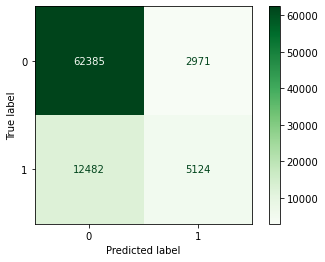

In [44]:
disp = ConfusionMatrixDisplay.from_estimator(
        logreg,
        X_test,
        Y_test,
        cmap=plt.cm.Greens)

print(disp.confusion_matrix)

### Model Tuning - Logistic Regression

In [45]:
solvers = ['newton-cg', 'lbfgs', 'liblinear'] 
penalty = ['l1','l2']
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
grid = dict(solver=solvers,penalty=penalty,C=c_values)

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=3, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
# summarize results

params = grid_result.cv_results_['params']
print(params)

[{'C': 0.001, 'penalty': 'l1', 'solver': 'newton-cg'}, {'C': 0.001, 'penalty': 'l1', 'solver': 'lbfgs'}, {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}, {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}, {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}, {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}, {'C': 0.01, 'penalty': 'l1', 'solver': 'newton-cg'}, {'C': 0.01, 'penalty': 'l1', 'solver': 'lbfgs'}, {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}, {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}, {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}, {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}, {'C': 0.1, 'penalty': 'l1', 'solver': 'newton-cg'}, {'C': 0.1, 'penalty': 'l1', 'solver': 'lbfgs'}, {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}, {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}, {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, {'C': 1, 'penalty': 'l1', 'solver': 'newton-cg'}, {'C': 1, 'penalty':

In [47]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.813425 using {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


Training final model with best hyperparameter

In [48]:
from sklearn.metrics import mean_squared_error
params = {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

logreg.set_params(**params)
clas = logreg.fit(X_train, Y_train)
predn = logreg.predict(X_test)
acc = roc_auc_score(Y_test,predn)

print(f'{clas} has AUC of {acc}')

LogisticRegression(C=1000) has AUC of 0.623759083648137


#### Classification Report

In [49]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_test, predn))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     65356
           1       0.63      0.29      0.40     17606

    accuracy                           0.81     82962
   macro avg       0.73      0.62      0.65     82962
weighted avg       0.79      0.81      0.79     82962



#### Confusion matrix

In [50]:
tnlog, fplog, fnlog, tplog = confusion_matrix(Y_test, predn).ravel()
print(confusion_matrix(Y_test, predn))

[[62367  2989]
 [12443  5163]]


[[62367  2989]
 [12443  5163]]


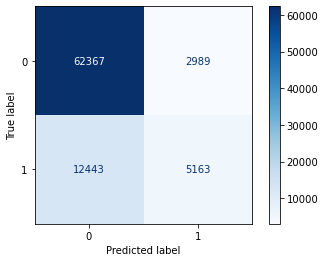

In [51]:
disp_fin1 = ConfusionMatrixDisplay.from_estimator(
        clas,
        X_test,
        Y_test,
        cmap=plt.cm.Blues)

print(disp_fin1.confusion_matrix)

### Feature Importance -Logistic Regression

Feature: 0, Score: 2.53854
Feature: 1, Score: -2.06416
Feature: 2, Score: 3.86204
Feature: 3, Score: 4.23708
Feature: 4, Score: 0.81945
Feature: 5, Score: -1.89546
Feature: 6, Score: 4.75393
Feature: 7, Score: -0.22495
Feature: 8, Score: -3.43760
Feature: 9, Score: 0.00127
Feature: 10, Score: 0.04161
Feature: 11, Score: -1.69724
Feature: 12, Score: 0.06373
Feature: 13, Score: 1.07929
Feature: 14, Score: 5.65709
Feature: 15, Score: -0.09564
Feature: 16, Score: 5.51456
Feature: 17, Score: -16.26763


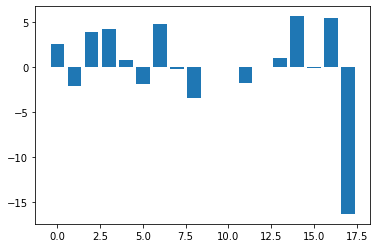

In [52]:
from matplotlib import pyplot
# get importance
importance = clas.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Permutation Feature Importance

In [53]:
from sklearn.inspection import permutation_importance
r = permutation_importance(clas, X_test, Y_test,
                            n_repeats=30,
                            random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{data.columns[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Bank    0.028 +/- 0.001
Zip     0.015 +/- 0.000
SBA_Appv0.015 +/- 0.000
City    0.005 +/- 0.000
GrAppv  0.004 +/- 0.000
LowDoc  0.003 +/- 0.000
NAICS   0.001 +/- 0.000
State   0.001 +/- 0.000
NoEmp   0.001 +/- 0.000
DisbursementGross0.001 +/- 0.000


### Boosted Trees - LGBM Classifier

In [54]:
from lightgbm import LGBMClassifier

In [55]:
model = LGBMClassifier()
model.fit(X_train,Y_train)
print(model.score(X_train, Y_train))
print(model.score(X_test, Y_test))

0.839681176452862
0.8369976615800004


In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,ConfusionMatrixDisplay
y_true = list(Y_test)
y_pred = list(model.predict(X_test))
r2_score(y_true, y_pred)

0.024996668514119857

In [57]:
result = pd.DataFrame({"Gradient Boosting with default parameters":[r2_score(y_true, y_pred),
                                                                  mean_absolute_error(y_true,y_pred),
                                                                  mean_squared_error(y_true, y_pred)]},index =['R-Squared','Mean Absolute Error','RMSE'])
                                                                                                        
result

Gradient Boosting with default parameters
R-Squared                                             0.024997
Mean Absolute Error                                   0.163002
RMSE                                                  0.163002

#### Confusion matrix from initial trained model

[[61965  3391]
 [10132  7474]]


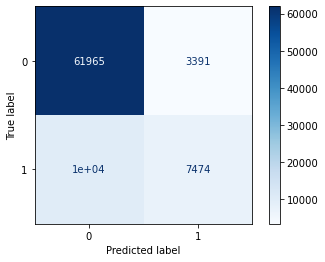

In [58]:
disp1 = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        Y_test,
        cmap=plt.cm.Blues)

print(disp1.confusion_matrix)

### Model Tuning - Boosted Trees

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
param_grid2 = { 
    'bagging_fraction': (0.5, 0.8),
    'feature_fraction': (0.5, 0.8),
    'max_depth': (8,10, 13),
    'min_data_in_leaf': (90, 120),
    'num_leaves': (100, 200,500)
 }

gscv_lgbm2 = GridSearchCV(model, param_grid2, scoring='neg_mean_squared_error', cv=3)
gscv_lgbm2.fit(X_train, Y_train)
yhat_lgbmr = gscv_lgbm2.predict(X_test)


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging

#### Best prameters after hyperparameter tuning

In [61]:
print(gscv_lgbm2.best_params_)

{'bagging_fraction': 0.5, 'feature_fraction': 0.5, 'max_depth': 13, 'min_data_in_leaf': 90, 'num_leaves': 500}


#### Training the final model with best parameters

In [62]:
params = {'bagging_fraction': 0.5, 'feature_fraction': 0.5, 'max_depth': 13, 'min_data_in_leaf': 90, 'num_leaves': 500}

model.set_params(**params)
reg = model.fit(X_train, Y_train)
pred = model.predict(X_test,predict_disable_shape_check=True)
rmse = np.sqrt(mean_squared_error(pred, Y_test))
print(f'{model} has rmse of {rmse}')

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
LGBMClassifier(bagging_fraction=0.5, feature_fraction=0.5, max_depth=13,
               min_data_in_leaf=90, num_leaves=500) has rmse of 0.39781047768119115


In [63]:
from sklearn.metrics import r2_score,confusion_matrix,mean_absolute_error, mean_squared_error

In [64]:
result_gbm = pd.DataFrame({"Gradient Boosting with default parameters":[r2_score(y_true, pred),
                                                                  mean_absolute_error(y_true,pred),
                                                                  mean_squared_error(y_true, pred)]},index =['R-Squared','Mean Absolute Error','MSE'])
                                                                                                        
result_gbm

Gradient Boosting with default parameters
R-Squared                                             0.053404
Mean Absolute Error                                   0.158253
MSE                                                   0.158253

#### Classification report 


In [65]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.90     65356
           1       0.70      0.45      0.55     17606

    accuracy                           0.84     82962
   macro avg       0.78      0.70      0.73     82962
weighted avg       0.83      0.84      0.83     82962



#### Confusion matrix

In [66]:
tnlgb, fplgb, fnlgb, tplgb = confusion_matrix(Y_test, pred).ravel()
print(confusion_matrix(Y_test, pred))

[[61863  3493]
 [ 9636  7970]]


[[61863  3493]
 [ 9636  7970]]


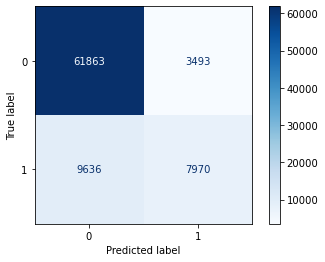

In [67]:
disp_fin = ConfusionMatrixDisplay.from_estimator(
        reg,
        X_test,
        Y_test,
        cmap=plt.cm.Blues)

print(disp_fin.confusion_matrix)

### Comparison of model performance - logistic Regression and LGBM Classifier

In [68]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
modelComparation = pd.DataFrame({
    "Logistic Regression": [accuracy_score(y_true, y_pred),precision_score(y_true, y_pred),recall_score(y_true, y_pred),f1_score(y_true, y_pred), tplog, tnlog, fplog, fnlog],
    "LGBM": [accuracy_score(y_true,pred),precision_score(y_true,pred),recall_score(y_true,pred),f1_score(y_true,pred), tplgb,tnlgb, fplgb, fnlgb],
}, index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'True Positive', 'True Negative', 'False Positive', 'False Negative'])
modelComparation

Logistic Regression          LGBM
Accuracy Score              0.836998      0.841747
Precision Score             0.687897      0.695280
Recall Score                0.424514      0.452687
F1 Score                    0.525025      0.548350
True Positive            5163.000000   7970.000000
True Negative           62367.000000  61863.000000
False Positive           2989.000000   3493.000000
False Negative          12443.000000   9636.000000

### Permutation feature Importance on final trained model

In [69]:
from sklearn.inspection import permutation_importance
r = permutation_importance(reg, X_test, Y_test,
                            n_repeats=30,
                            random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{data.columns[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Bank    0.035 +/- 0.001
Zip     0.023 +/- 0.001
NAICS   0.018 +/- 0.001
SBA_Appv0.011 +/- 0.000
BankState0.011 +/- 0.001
DisbursementGross0.011 +/- 0.001
RevLineCr0.010 +/- 0.000
City    0.009 +/- 0.000
LowDoc  0.007 +/- 0.000
NewExist0.006 +/- 0.000
GrAppv  0.005 +/- 0.000
State   0.003 +/- 0.001
UrbanRural0.003 +/- 0.000
CreateJob0.001 +/- 0.000
RetainedJob0.001 +/- 0.000
FranchiseCode0.001 +/- 0.000


In [70]:
import shap
shap.initjs()

In [71]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

#### SHAP Summary Plot

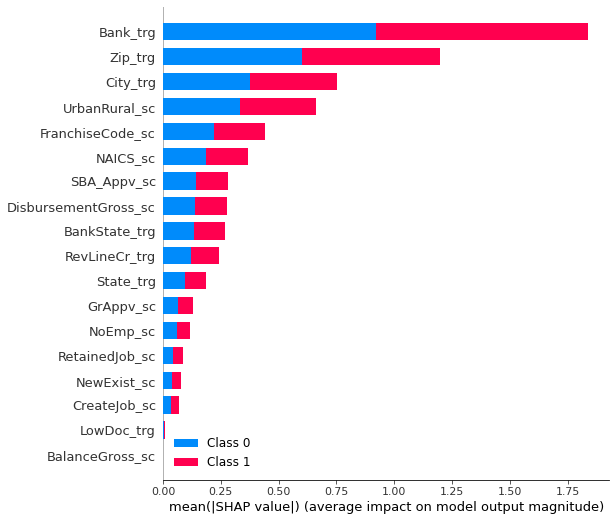

In [72]:
shap.summary_plot(shap_values, X_test)

### Saving all artifacts


Saving the model

In [73]:
import pickle
filename = 'lgbm_model.sav'
pickle.dump(reg, open(filename, 'wb'))

In [74]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
result

0.8417468238470626

Saving the encoders

In [75]:
filename1 = 'categorical_encoders.sav'
pickle.dump(cat_encoders, open(filename1, 'wb'))
 

In [76]:
loaded_encoders = pickle.load(open(filename1, 'rb'))
loaded_encoders

{'City': [TargetEncoder(cols=['City']), 'trg'],
 'State': [TargetEncoder(cols=['State']), 'trg'],
 'Zip': [TargetEncoder(cols=['Zip']), 'trg'],
 'Bank': [TargetEncoder(cols=['Bank']), 'trg'],
 'BankState': [TargetEncoder(cols=['BankState']), 'trg'],
 'RevLineCr': [TargetEncoder(cols=['RevLineCr']), 'trg'],
 'LowDoc': [TargetEncoder(cols=['LowDoc']), 'trg']}

Saving the scalers

In [77]:
filename2 = 'scalers.sav'
pickle.dump(num_scalers, open(filename2, 'wb'))

In [78]:
loaded_scalers = pickle.load(open(filename2, 'rb'))
loaded_scalers

{'NAICS': [MinMaxScaler(), 'MinMax'],
 'NoEmp': [MinMaxScaler(), 'MinMax'],
 'NewExist': [MinMaxScaler(), 'MinMax'],
 'CreateJob': [MinMaxScaler(), 'MinMax'],
 'RetainedJob': [MinMaxScaler(), 'MinMax'],
 'FranchiseCode': [MinMaxScaler(), 'MinMax'],
 'UrbanRural': [MinMaxScaler(), 'MinMax'],
 'DisbursementGross': [MinMaxScaler(), 'MinMax'],
 'BalanceGross': [MinMaxScaler(), 'MinMax'],
 'GrAppv': [MinMaxScaler(), 'MinMax'],
 'SBA_Appv': [MinMaxScaler(), 'MinMax']}

### Observation analysis based on error between prediction and response

In [79]:
a = X_test.copy()
a["error"] = (Y_test - pred)

In [80]:
a

City_trg  State_trg   Zip_trg  Bank_trg  BankState_trg  RevLineCr_trg  \
728661  0.080000   0.309744  0.083333  0.183880       0.234629       0.258146   
280981  0.172414   0.108098  0.155172  0.131679       0.062417       0.180957   
86663   0.213820   0.206520  0.238095  0.000000       0.122314       0.180957   
590553  0.380191   0.329000  0.250000  0.210759       0.234629       0.258146   
253329  0.147059   0.163345  0.190476  0.242432       0.223422       0.258146   
...          ...        ...       ...       ...            ...            ...   
271369  0.166667   0.108793  0.153846  0.226212       0.193645       0.258146   
494959  0.150649   0.241059  0.119048  0.280307       0.223422       0.258146   
704618  0.200000   0.170526  0.275862  0.061224       0.094148       0.180957   
578923  0.396646   0.276244  0.384615  0.242432       0.223422       0.258146   
583901  0.177632   0.197749  0.111111  0.396646       0.156883       0.180957   

        LowDoc_trg  NAICS_sc  NoEmp_sc  NewExist_sc  CreateJob_sc  \
728661    0.223040  0.407682  0.000600          0.0      0.000000   
280981    0.223040  0.151773  0.002000          1.0      0.000000   
86663     0.223040  0.746625  0.000100          1.0      0.002135   
590553    0.223040  0.856883  0.000400          0.0      0.000712   
253329    0.223040  0.551192  0.000200          0.0      0.000000   
...            ...       ...       ...          ...           ...   
271369    0.223040  0.551171  0.015002          0.0      0.000000   
494959    0.223040  0.526923  0.000200          0.0      0.000356   
704618    0.049065  0.489602  0.000200          1.0      0.000000   
578923    0.223040  0.526433  0.000300          0.0      0.000000   
583901    0.223040  0.527264  0.000500          1.0      0.000000   

        RetainedJob_sc  FranchiseCode_sc  UrbanRural_sc  DisbursementGross_sc  \
728661        0.001351          0.000010            0.5              0.001310   
280981        0.000000          0.000010            1.0              0.017910   
86663         0.000000          0.464135            0.5              0.166342   
590553        0.000901          0.000010            0.5              0.008494   
253329        0.000450          0.000010            0.5              0.000437   
...                ...               ...            ...                   ...   
271369        0.033776          0.000010            0.5              0.008738   
494959        0.000901          0.000010            0.5              0.014522   
704618        0.000000          0.000010            0.0              0.002184   
578923        0.000676          0.000000            0.5              0.001202   
583901        0.000000          0.000010            1.0              0.023588   

        BalanceGross_sc  GrAppv_sc  SBA_Appv_sc  error  
728661              0.0   0.002960     0.001644      0  
280981              0.0   0.040962     0.034145      1  
86663               0.0   0.385175     0.427987      0  
590553              0.0   0.009960     0.005533      1  
253329              0.0   0.000960     0.000533      0  
...                 ...        ...          ...    ...  
271369              0.0   0.019961     0.011089      0  
494959              0.0   0.009960     0.005533      0  
704618              0.0   0.004960     0.004422      0  
578923              0.0   0.000960     0.000533      1  
583901              0.0   0.053962     0.044979      0  

[82962 rows x 19 columns]

In [81]:
a.sort_values(by = ["error"])

City_trg  State_trg   Zip_trg  Bank_trg  BankState_trg  RevLineCr_trg  \
252463  0.370370   0.212214  0.285714  0.407949       0.284007       0.180957   
438679  0.213526   0.263544  0.179245  0.324954       0.278171       0.258146   
500100  0.658273   0.276244  0.499739  0.149203       0.193645       0.258146   
383227  0.479495   0.329000  0.487179  0.324954       0.278171       0.258146   
506067  0.125081   0.092000  0.097561  0.495053       0.243857       0.180957   
...          ...        ...       ...       ...            ...            ...   
44327   0.315126   0.263544  0.435484  0.351220       0.215144       0.258146   
381241  0.171889   0.146831  0.164179  0.183880       0.234629       0.258146   
548439  0.240741   0.299134  0.312500  0.150000       0.102002       0.180957   
545011  0.319052   0.272812  0.095238  0.468904       0.458921       0.180957   
171859  0.250000   0.213932  0.203704  0.092437       0.295020       0.180957   

        LowDoc_trg  NAICS_sc  NoEmp_sc  NewExist_sc  CreateJob_sc  \
252463     0.22304  0.526433    0.0003          1.0      0.000000   
438679     0.22304  0.857248    0.0001          0.0      0.000000   
500100     0.22304  0.461928    0.0001          1.0      0.000000   
383227     0.22304  0.526443    0.0003          0.0      0.000534   
506067     0.22304  0.418734    0.0001          0.0      0.000000   
...            ...       ...       ...          ...           ...   
44327      0.22304  0.551548    0.0002          0.0      0.000178   
381241     0.22304  0.412516    0.0005          0.0      0.000356   
548439     0.22304  0.407706    0.0006          1.0      0.000000   
545011     0.22304  0.419579    0.0004          0.0      0.000000   
171859     0.22304  0.858009    0.0001          1.0      0.000534   

        RetainedJob_sc  FranchiseCode_sc  UrbanRural_sc  DisbursementGross_sc  \
252463        0.000676           0.00000            0.5              0.023588   
438679        0.000225           0.00001            1.0              0.005643   
500100        0.000225           0.00000            0.5              0.008999   
383227        0.001351           0.00000            0.5              0.004384   
506067        0.000225           0.00000            1.0              0.002184   
...                ...               ...            ...                   ...   
44327         0.000450           0.00001            0.5              0.000874   
381241        0.001576           0.00001            0.5              0.010339   
548439        0.000000           0.00001            1.0              0.021841   
545011        0.000000           0.00001            0.5              0.004368   
171859        0.000901           0.00000            0.5              0.017691   

        BalanceGross_sc  GrAppv_sc  SBA_Appv_sc  error  
252463              0.0   0.053962     0.044979     -1  
438679              0.0   0.004960     0.002756     -1  
500100              0.0   0.009960     0.005533     -1  
383227              0.0   0.009960     0.005533     -1  
506067              0.0   0.004960     0.004700     -1  
...                 ...        ...          ...    ...  
44327               0.0   0.001960     0.001089      1  
381241              0.0   0.013961     0.007756      1  
548439              0.0   0.049962     0.041645      1  
545011              0.0   0.009960     0.005533      1  
171859              0.0   0.040462     0.033729      1  

[82962 rows x 19 columns]

In [100]:
a.loc[a['error'] == -1]  # finding observations with true value of 1 , predicted value of 1 and error of 0

City_trg  State_trg   Zip_trg  Bank_trg  BankState_trg  RevLineCr_trg  \
610837  0.215909   0.241059  0.309524  0.280307       0.295020       0.258146   
365272  0.210526   0.223764  0.176991  0.539683       0.215144       0.258146   
790640  0.213526   0.263544  0.222219  0.495053       0.243857       0.180957   
633677  0.304348   0.299134  0.375000  0.407949       0.284007       0.180957   
464869  0.245037   0.206520  0.428571  0.684933       0.284007       0.180957   
...          ...        ...       ...       ...            ...            ...   
730918  0.221311   0.263544  0.202381  0.324954       0.278171       0.258146   
69242   0.364865   0.299134  0.333333  0.280307       0.295020       0.258146   
38927   0.220467   0.163345  0.372881  0.242432       0.223422       0.180957   
584224  0.292639   0.263544  0.376923  0.280307       0.295020       0.258146   
512444  0.612651   0.241059  0.612903  0.183880       0.234629       0.180957   

        LowDoc_trg  NAICS_sc  NoEmp_sc  NewExist_sc  CreateJob_sc  \
610837     0.22304  0.419825    0.0002          0.0      0.000712   
365272     0.22304  0.551548    0.0003          0.0      0.000000   
790640     0.22304  0.857248    0.0001          0.0      0.000000   
633677     0.22304  0.737849    0.0000          1.0      0.000178   
464869     0.22304  0.381893    0.0003          0.0      0.000000   
...            ...       ...       ...          ...           ...   
730918     0.22304  0.405367    0.0001          0.0      0.000000   
69242      0.22304  0.410141    0.0001          0.0      0.000000   
38927      0.22304  0.624484    0.0004          0.0      0.000712   
584224     0.22304  0.747849    0.0013          1.0      0.000000   
512444     0.22304  0.259494    0.0001          1.0      0.000534   

        RetainedJob_sc  FranchiseCode_sc  UrbanRural_sc  DisbursementGross_sc  \
610837        0.001351           0.00000            0.5              0.010795   
365272        0.000676           0.00000            0.5              0.004334   
790640        0.000225           0.00000            0.5              0.004368   
633677        0.000000           0.00000            0.5              0.025633   
464869        0.000676           0.00000            0.5              0.002184   
...                ...               ...            ...                   ...   
730918        0.000225           0.00001            0.5              0.009776   
69242         0.000225           0.00000            0.5              0.004237   
38927         0.001801           0.00000            0.5              0.004980   
584224        0.002927           0.00000            0.5              0.006962   
512444        0.000225           0.00000            0.5              0.027887   

        BalanceGross_sc  GrAppv_sc  SBA_Appv_sc  error  
610837              0.0   0.009960     0.005533     -1  
365272              0.0   0.004960     0.002756     -1  
790640              0.0   0.009960     0.009422     -1  
633677              0.0   0.058642     0.048879     -1  
464869              0.0   0.004960     0.004978     -1  
...                 ...        ...          ...    ...  
730918              0.0   0.008960     0.004978     -1  
69242               0.0   0.004960     0.002756     -1  
38927               0.0   0.011360     0.006311     -1  
584224              0.0   0.008260     0.004589     -1  
512444              0.0   0.063803     0.053179     -1  

[3493 rows x 19 columns]

#### Observation 44327 has true_value 1, but classified as 0. So, error is 1. Same is true for observation 381241

In [89]:
shap.force_plot(explainer.expected_value[0], shap_values[0][44327], X_test.iloc[44327,:].values,feature_names = X_test.columns)

In [91]:
shap.force_plot(explainer.expected_value[1], shap_values[1][44327], X_test.iloc[44327,:].values,feature_names = X_test.columns)

#### Observation 20672 has true_value 0, and classified as 0. So, error is 0. Same is true for observation 86663

In [95]:
shap.force_plot(explainer.expected_value[0], shap_values[0][20672], X_test.iloc[20672,:].values,feature_names = X_test.columns)

In [96]:
shap.force_plot(explainer.expected_value[1], shap_values[1][20672], X_test.iloc[20672,:].values,feature_names = X_test.columns)

#### Observation 69242 has true_value 0, but classified as 1. So, error is -1. Same is true for observation 38927

In [101]:
shap.force_plot(explainer.expected_value[0], shap_values[0][69242], X_test.iloc[69242,:].values,feature_names = X_test.columns)

In [103]:
shap.force_plot(explainer.expected_value[1], shap_values[1][69242], X_test.iloc[69242,:].values,feature_names = X_test.columns)

In [104]:
shap.force_plot(explainer.expected_value[0], shap_values[0][38927], X_test.iloc[38927,:].values,feature_names = X_test.columns)

In [102]:
shap.force_plot(explainer.expected_value[1], shap_values[1][38927], X_test.iloc[38927,:].values,feature_names = X_test.columns)

#### Observation 268549 has true_value 1, and classified as 1. So, error is 0. Same is true for observation 605876